In [1]:
cd /home/blansdel/projects/brett_dlc/animal_pilot

/home/blansdel/projects/brett_dlc/animal_pilot


In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from matplotlib import cm
from glob import glob

from behaveml import load_sklearn_model, load_videodataset
from scipy.stats import binom, fisher_exact, ranksums

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from matplotlib import pyplot as plt

interaction_threshold = 7

TEMPLATE = 'e3v813a'

#TEST_GROUP_IDS = [1,2,3,4,5,6,8,9,10,11,14,15,19,20,21,22,24,25,26,29]
TEST_GROUP_IDS = [7,12,13,16,17,18,23,27,28]

In [4]:
def plot_scatter_w_legend(x, y, c, ldict, cdict = {True: 'red', False: 'blue'}, size = 30, **kwargs):
    group = c
    fig, ax = plt.subplots(**kwargs)
    for g in np.unique(group):
        ix = np.where(group == g)
        ax.scatter(x[ix], y[ix], c = cdict[g], label = ldict[g], s = size)
    ax.legend()
    return fig, ax

In [5]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [6]:
test_dataset = load_videodataset('./analysis/dataset_test_brett_donnie_agree.pkl')
dataset = load_videodataset('./analysis/dataset_training_brett_donnie_agree.pkl')

## Basic stats

In [7]:
#Collect interaction times from videos
for vid in test_dataset.videos:
    n_interaction = len(test_dataset.data.loc[(test_dataset.data['filename'] == vid) & (test_dataset.data['prediction'] == 1)])
    test_dataset.metadata[vid]['n_predicted_interaction'] = n_interaction

results = pd.DataFrame.from_dict(test_dataset.metadata, orient = 'index')
results = results.reset_index().rename(columns = {'index': 'filename'})
results['predicted_interaction_time'] = results['n_predicted_interaction']/results['fps']
results['predicted_interaction_percent'] = 100*results['predicted_interaction_time']/results['duration']

#Map to original video names
vid_names = {}
for dr in glob('./raw_videos/social_*'):
    fn = glob(os.path.join(dr, f'{TEMPLATE}*'))[0]
    vid_names['-'.join(os.path.basename(fn).split('-')[:2])] = dr.split('/')[-1]

results['vid_name'] = results['filename'].apply(lambda x: vid_names['-'.join(os.path.basename(x).split('-')[:2])])
results['trial'] = results['vid_name'].apply(lambda x: x.split('_')[1])
results['repeat'] = results['vid_name'].apply(lambda x: 're' in x)
results['test_group_'] = results['trial'].apply(lambda x: int(x) in TEST_GROUP_IDS)

concise_results = results[['duration', 'predicted_interaction_time',
                           'predicted_interaction_percent', 'repeat', 'trial']]
concise_results['test_group'] = concise_results['trial'].apply(lambda x: int(x) in TEST_GROUP_IDS)
concise_results = concise_results.set_index('trial')

repeat_results = concise_results.loc[concise_results['repeat'] == True, ['predicted_interaction_percent']].rename(columns = {'predicted_interaction_percent': 'predicted_interaction_percent_repeat'})

concise_results = pd.concat([concise_results.loc[concise_results['repeat'] == False], 
                             repeat_results], axis = 1)
concise_results['change_in_pct'] = concise_results['predicted_interaction_percent_repeat'] - concise_results['predicted_interaction_percent']
concise_results['increase_in_pct'] = concise_results['change_in_pct'] > 0
concise_results

concise_results_w_threhsold = concise_results[concise_results['predicted_interaction_percent'] > interaction_threshold]

In [8]:
print("Test group")
concise_results[concise_results['test_group'] == True]

Test group


,duration,predicted_interaction_time,predicted_interaction_percent,repeat,test_group,predicted_interaction_percent_repeat,change_in_pct,increase_in_pct
trial,,,,,,,,
7,305.866667,27.300000,8.925458,False,True,19.875369,10.949911,True
12,303.933333,23.633333,7.775828,False,True,11.880631,4.104803,True
13,302.000000,31.633333,10.474614,False,True,5.704475,-4.770139,False
16,302.933333,20.833333,6.877201,False,True,8.574277,1.697076,True
17,298.833333,18.600000,6.224205,False,True,1.617518,-4.606688,False
18,299.966667,4.866667,1.622402,False,True,5.320088,3.697686,True
23,301.966667,21.500000,7.119991,False,True,19.116331,11.996340,True
27,300.000000,5.000000,1.666667,False,True,1.556463,-0.110203,False
28,306.000000,13.666667,4.466231,False,True,7.003367,2.537136,True


In [9]:
print("Control group")
concise_results[concise_results['test_group'] == False]

Control group


,duration,predicted_interaction_time,predicted_interaction_percent,repeat,test_group,predicted_interaction_percent_repeat,change_in_pct,increase_in_pct
trial,,,,,,,,
1,327.933333,34.466667,10.510266,False,False,8.718933,-1.791333,False
2,296.966667,17.700000,5.960265,False,False,1.874099,-4.086166,False
3,332.933333,14.466667,4.345214,False,False,17.404580,13.059366,True
4,305.966667,61.800000,20.198279,False,False,30.989325,10.791047,True
5,272.800000,25.066667,9.188661,False,False,8.627974,-0.560687,False
6,304.833333,11.333333,3.717879,False,False,8.074602,4.356724,True
8,304.966667,13.100000,4.295551,False,False,3.885098,-0.410453,False
9,303.800000,36.366667,11.970595,False,False,7.194719,-4.775875,False
10,297.000000,28.500000,9.595960,False,False,5.699308,-3.896651,False


In [10]:
#Summarize effect
print("test group first interaction %", np.mean(concise_results.loc[concise_results['test_group'] == True, 'predicted_interaction_percent']))
print("control group first interaction %", np.mean(concise_results.loc[concise_results['test_group'] == False, 'predicted_interaction_percent']))

test group first interaction % 6.12806629369642
control group first interaction % 7.903625992571476


In [11]:
#Summarize effect
print("test group repeat interaction %", np.mean(concise_results.loc[concise_results['test_group'] == True, 'predicted_interaction_percent_repeat']))
print("control group repeat interaction %", np.mean(concise_results.loc[concise_results['test_group'] == False, 'predicted_interaction_percent_repeat']))

test group repeat interaction % 8.960946547836626
control group repeat interaction % 8.249517002007275


In [12]:
#Summarize effect
print("test group mean change in interaction %", np.mean(concise_results.loc[concise_results['test_group'] == True, 'change_in_pct']))
print("control group mean change in interaction %", np.mean(concise_results.loc[concise_results['test_group'] == False, 'change_in_pct']))

test group mean change in interaction % 2.832880254140205
control group mean change in interaction % 0.3458910094357982


In [13]:
print("test group median change in interaction %", np.median(concise_results.loc[concise_results['test_group'] == True, 'change_in_pct']))
print("control group median change in interaction %", np.median(concise_results.loc[concise_results['test_group'] == False, 'change_in_pct']))

test group median change in interaction % 2.5371360665478315
control group median change in interaction % -0.6134493621035482


In [14]:
ranksums(concise_results.loc[concise_results['test_group'] == True, 'change_in_pct'], concise_results.loc[concise_results['test_group'] == False, 'change_in_pct'])

RanksumsResult(statistic=1.2256517540566823, pvalue=0.2203297530976842)

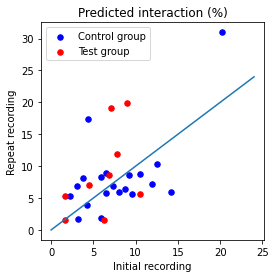

In [21]:
plot_scatter_w_legend(concise_results['predicted_interaction_percent'].to_numpy(), 
                      concise_results['predicted_interaction_percent_repeat'].to_numpy(), 
                      concise_results['test_group'].to_numpy(), 
                      {True: 'Test group', False: 'Control group'}, 
                      figsize = (4,4))
plt.plot(np.arange(25))
plt.xlabel('Initial recording')
plt.ylabel('Repeat recording');
plt.title('Predicted interaction (%)')
plt.savefig('./change_in_interaction_pcts.pdf')

In [21]:
n = len(concise_results[concise_results['test_group'] == True])
p = 11/20
x = 2/n
prob = 2*binom.cdf(x, n, p)
print('p-value using two-sided binomial test:', prob)

p-value using two-sided binomial test: 0.0015133612851562486


In [24]:
a11 = len(concise_results[(concise_results['test_group'] == False) & (concise_results['increase_in_pct'] == False)])
a21 = len(concise_results[(concise_results['test_group'] == False) & (concise_results['increase_in_pct'] == True)])
a12 = len(concise_results[(concise_results['test_group'] == True) & (concise_results['increase_in_pct'] == False)])
a22 = len(concise_results[(concise_results['test_group'] == True) & (concise_results['increase_in_pct'] == True)])

table = [[a11, a12], [a21, a22]]
table
#oddsr, p = fisher_exact(table)
#oddsr, p = barnard_exact(table)
#p = 


[[13, 3], [7, 6]]

In [113]:
#z-test

p1 = 11/20
p2 = 2/9
n1 = 20
n2 = 9
p = (n1*p1 + n2*p2)/(n1 + n2)
z = (p1 - p2)/np.sqrt(p*(1-p)*(1/n1 + 1/n2))
z

1.6420375736146826

### Repeat with threshold applied

In [20]:
#Summarize effect
print("test group first interaction %", np.mean(concise_results_w_threhsold.loc[concise_results_w_threhsold['test_group'] == True, 'predicted_interaction_percent']))
print("control group first interaction %", np.mean(concise_results_w_threhsold.loc[concise_results_w_threhsold['test_group'] == False, 'predicted_interaction_percent']))

test group first interaction % 8.573972650945244
control group first interaction % 11.227209919412761


In [21]:
#Summarize effect
print("test group repeat interaction %", np.mean(concise_results_w_threhsold.loc[concise_results_w_threhsold['test_group'] == True, 'predicted_interaction_percent_repeat']))
print("control group repeat interaction %", np.mean(concise_results_w_threhsold.loc[concise_results_w_threhsold['test_group'] == False, 'predicted_interaction_percent_repeat']))

test group repeat interaction % 14.144201416757866
control group repeat interaction % 9.670346187290555


In [22]:
#Summarize effect
print("test group mean change in interaction %", np.mean(concise_results_w_threhsold.loc[concise_results_w_threhsold['test_group'] == True, 'change_in_pct']))
print("control group mean change in interaction %", np.mean(concise_results_w_threhsold.loc[concise_results_w_threhsold['test_group'] == False, 'change_in_pct']))

test group mean change in interaction % 5.5702287658126215
control group mean change in interaction % -1.5568637321222059


In [233]:
print("test group median change in interaction %", np.median(concise_results_w_threhsold.loc[concise_results_w_threhsold['test_group'] == True, 'change_in_pct']))
print("control group median change in interaction %", np.median(concise_results_w_threhsold.loc[concise_results_w_threhsold['test_group'] == False, 'change_in_pct']))

test group median change in interaction % 7.014819711134692
control group median change in interaction % -1.7863816044549967


In [23]:
ranksums(concise_results_w_threhsold.loc[concise_results_w_threhsold['test_group'] == True, 'change_in_pct'], concise_results_w_threhsold.loc[concise_results_w_threhsold['test_group'] == False, 'change_in_pct'])

RanksumsResult(statistic=1.5556349186104046, pvalue=0.11979493042591832)

In [19]:
##Fisher exact test
a11 = len(concise_results_w_threhsold[(concise_results_w_threhsold['test_group'] == False) & (concise_results_w_threhsold['increase_in_pct'] == False)])
a21 = len(concise_results_w_threhsold[(concise_results_w_threhsold['test_group'] == False) & (concise_results_w_threhsold['increase_in_pct'] == True)])
a12 = len(concise_results_w_threhsold[(concise_results_w_threhsold['test_group'] == True) & (concise_results_w_threhsold['increase_in_pct'] == False)])
a22 = len(concise_results_w_threhsold[(concise_results_w_threhsold['test_group'] == True) & (concise_results_w_threhsold['increase_in_pct'] == True)])

table = [[a11, a12], [a21, a22]]
table
#oddsr, p = fisher_exact(table)
from scipy.stats import barnard_exact
oddsr, p = barnard_exact(table)
p = 0.0149


ImportError: cannot import name 'barnard_exact'

In [20]:
table

[[9, 1], [1, 3]]

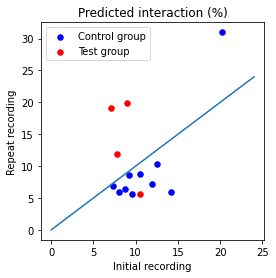

In [22]:
plot_scatter_w_legend(concise_results_w_threhsold['predicted_interaction_percent'].to_numpy(), 
                      concise_results_w_threhsold['predicted_interaction_percent_repeat'].to_numpy(), 
                      concise_results_w_threhsold['test_group'].to_numpy(), 
                      {True: 'Test group', False: 'Control group'}, 
                      figsize = (4,4))
plt.plot(np.arange(25))
plt.xlabel('Initial recording')
plt.ylabel('Repeat recording');
plt.title('Predicted interaction (%)')
plt.savefig('./change_in_interaction_pcts_w_threshold.pdf')

In [21]:
n = len(concise_results[concise_results['test_group'] == True])
p = 11/20
x = 2/n
prob = 2*binom.cdf(x, n, p)
print('p-value using two-sided binomial test:', prob)

p-value using two-sided binomial test: 0.0015133612851562486


## Diagnostic plots

* Plot ethogram for each video
* Plot interaction time vs simple metrics
* TSNE embeddings for simple metrics, measured by control group

### Behavior plots

In [ ]:
results

,filename,video_files,units,fps,resolution,frame_length,duration,scorer,n_predicted_interaction,predicted_interaction_time,predicted_interaction_percent,vid_name,trial,repeat,test_group_
0,./all_videos/e3v813a-20211001T121054-121622DLC...,./all_videos/e3v813a-20211001T121054-121622.avi,None,30,"(1200, 1600)",None,327.933333,DLC_dlcrnetms5_pilot_studySep24shuffle1_100000,1188,39.600000,12.075625,social_1,1,False,False
1,./all_videos/e3v813a-20211001T122726-123223DLC...,./all_videos/e3v813a-20211001T122726-123223.avi,None,30,"(1200, 1600)",None,296.966667,DLC_dlcrnetms5_pilot_studySep24shuffle1_100000,667,22.233333,7.486811,social_2,2,False,False
2,./all_videos/e3v813a-20211001T123846-124419DLC...,./all_videos/e3v813a-20211001T123846-124419.avi,None,30,"(1200, 1600)",None,332.933333,DLC_dlcrnetms5_pilot_studySep24shuffle1_100000,518,17.266667,5.186223,social_3,3,False,False
3,./all_videos/e3v813a-20211001T125501-130007DLC...,./all_videos/e3v813a-20211001T125501-130007.avi,None,30,"(1200, 1600)",None,305.966667,DLC_dlcrnetms5_pilot_studySep24shuffle1_100000,2165,72.166667,23.586447,social_4,4,False,False
4,./all_videos/e3v813a-20211001T132205-132735DLC...,./all_videos/e3v813a-20211001T132205-132735.avi,None,30,"(1200, 1600)",None,329.933333,DLC_dlcrnetms5_pilot_studySep24shuffle1_100000,1025,34.166667,10.355627,social_1_re,1,True,False
5,./all_videos/e3v813a-20211001T133723-134310DLC...,./all_videos/e3v813a-20211001T133723-134310.avi,None,30,"(1200, 1600)",None,346.833333,DLC_dlcrnetms5_pilot_studySep24shuffle1_100000,356,11.866667,3.421432,social_2_re,2,True,False
6,./all_videos/e3v813a-20211001T135129-135613DLC...,./all_videos/e3v813a-20211001T135129-135613.avi,None,30,"(1200, 1600)",None,283.833333,DLC_dlcrnetms5_pilot_studySep24shuffle1_100000,1595,53.166667,18.731650,social_3_re,3,True,False
7,./all_videos/e3v813a-20211001T140617-141120DLC...,./all_videos/e3v813a-20211001T140617-141120.avi,None,30,"(1200, 1600)",None,302.900000,DLC_dlcrnetms5_pilot_studySep24shuffle1_100000,3281,109.366667,36.106526,social_4_re,4,True,False
8,./all_videos/e3v813a-20211006T110049-110522DLC...,./all_videos/e3v813a-20211006T110049-110522.avi,None,30,"(1200, 1600)",None,272.800000,DLC_dlcrnetms5_pilot_studySep24shuffle1_100000,922,30.733333,11.265885,social_5,5,False,False
9,./all_videos/e3v813a-20211006T111208-111713DLC...,./all_videos/e3v813a-20211006T111208-111713.avi,None,30,"(1200, 1600)",None,304.833333,DLC_dlcrnetms5_pilot_studySep24shuffle1_100000,478,15.933333,5.226900,social_6,6,False,False


In [74]:
#Prepare a matrix to show via imshow
n_resolution = 1000
n_vids = len(test_dataset.metadata)

pred_matrix_control_first = []
pred_matrix_control_second = []
pred_matrix_test_first = []
pred_matrix_test_second = []

#prediction_matrix = np.zeros((n_vids, n_resolution))

for idx, fn in enumerate(test_dataset.metadata.keys()):
    row = results.iloc[idx,:]
    fn = row['filename']
    repeat = row['repeat']
    test_group = row['test_group_']

    #print(fn, repeat, test_group)
    d = test_dataset.data.loc[test_dataset.data['filename'] == fn]
    x = np.linspace(0, len(d)-1, n_resolution)
    xp = np.arange(len(d))
    intr = np.interp(x, xp, d['prediction'].to_numpy())

    if repeat:
        if test_group:
            pred_matrix_test_second.append(intr)
        else:
            pred_matrix_control_second.append(intr)
    else:
        if test_group:
            pred_matrix_test_first.append(intr)
        else:
            pred_matrix_control_first.append(intr)

pred_matrix_control_first = np.array(pred_matrix_control_first)
pred_matrix_control_second = np.array(pred_matrix_control_second)
pred_matrix_test_first = np.array(pred_matrix_test_first)
pred_matrix_test_second = np.array(pred_matrix_test_second)

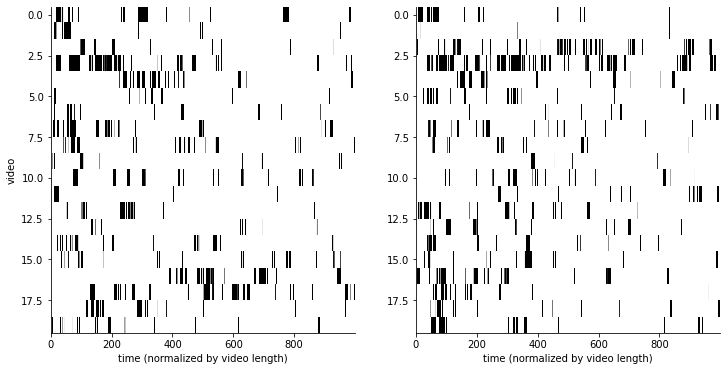

In [75]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize = (12,6), sharex = True)
ax[0].imshow(pred_matrix_control_first, aspect = 'auto', interpolation = 'none', cmap = 'Greys')
ax[1].imshow(pred_matrix_control_second, aspect = 'auto', interpolation = 'none', cmap = 'Greys')
sns.despine()
ax[1].set_xlabel('time (normalized by video length)')
ax[0].set_xlabel('time (normalized by video length)')
ax[0].set_ylabel('video');
plt.savefig('./control_predicted_interactions.png', dpi = 100)

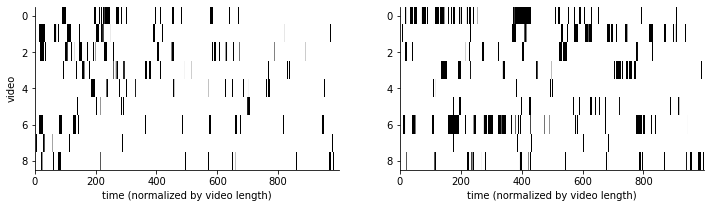

In [76]:
fig, ax = plt.subplots(1, 2, figsize = (12,3), sharex = True)
ax[0].imshow(pred_matrix_test_first, aspect = 'auto', interpolation = 'none', cmap = 'Greys')
ax[1].imshow(pred_matrix_test_second, aspect = 'auto', interpolation = 'none', cmap = 'Greys')
sns.despine()
ax[1].set_xlabel('time (normalized by video length)')
ax[0].set_xlabel('time (normalized by video length)')
ax[0].set_ylabel('video');
plt.savefig('./test_predicted_interactions.png', dpi = 100)

### Repeat with much lower resolution, to try to summarize trends

In [80]:
#Prepare a matrix to show via imshow
n_resolution = 5
n_vids = len(test_dataset.metadata)

pred_matrix_control_first = []
pred_matrix_control_second = []
pred_matrix_test_first = []
pred_matrix_test_second = []

name_pred_matrix_control_first = []
name_pred_matrix_control_second = []
name_pred_matrix_test_first = []
name_pred_matrix_test_second = []

#prediction_matrix = np.zeros((n_vids, n_resolution))

for idx, fn in enumerate(test_dataset.metadata.keys()):
    row = results.iloc[idx,:]
    fn = row['filename']
    repeat = row['repeat']
    test_group = row['test_group_']

    #print(fn, repeat, test_group)
    d = test_dataset.data.loc[test_dataset.data['filename'] == fn]
    x = np.linspace(0, len(d)-1, n_resolution+1).astype(int)

    intr = [np.mean(d['prediction'].to_numpy()[x[i]:x[i+1]]) for i in range(n_resolution)]

    if repeat:
        if test_group:
            pred_matrix_test_second.append(intr)
            name_pred_matrix_test_second.append(fn)

        else:
            pred_matrix_control_second.append(intr)
            name_pred_matrix_control_second.append(fn)
    else:
        if test_group:
            pred_matrix_test_first.append(intr)
            name_pred_matrix_test_first.append(fn)
        else:
            pred_matrix_control_first.append(intr)
            name_pred_matrix_control_first.append(fn)
            
pred_matrix_control_first = np.array(pred_matrix_control_first)
pred_matrix_control_second = np.array(pred_matrix_control_second)
pred_matrix_test_first = np.array(pred_matrix_test_first)
pred_matrix_test_second = np.array(pred_matrix_test_second)

In [81]:
n_test = pred_matrix_test_second.shape[0]
n_control = pred_matrix_control_second.shape[0]

In [82]:
pred_matrix_control_first_norm = pred_matrix_control_first/np.tile(np.max(pred_matrix_control_first, axis = 1), (5,1)).T
pred_matrix_control_first_norm_se = np.std(pred_matrix_control_first_norm, axis = 0)/np.sqrt(n_control)
pred_matrix_control_first_norm = np.mean(pred_matrix_control_first_norm, axis = 0)

pred_matrix_control_second_norm = pred_matrix_control_second/np.tile(np.max(pred_matrix_control_second, axis = 1), (5,1)).T
pred_matrix_control_second_norm_se = np.std(pred_matrix_control_second_norm, axis = 0)/np.sqrt(n_control)
pred_matrix_control_second_norm = np.mean(pred_matrix_control_second_norm, axis = 0)

pred_matrix_test_first_norm = pred_matrix_test_first/np.tile(np.max(pred_matrix_test_first, axis = 1), (5,1)).T
pred_matrix_test_first_norm_se = np.std(pred_matrix_test_first_norm, axis = 0)/np.sqrt(n_test)
pred_matrix_test_first_norm = np.mean(pred_matrix_test_first_norm, axis = 0)

pred_matrix_test_second_norm = pred_matrix_test_second/np.tile(np.max(pred_matrix_test_second, axis = 1), (5,1)).T
pred_matrix_test_second_norm_se = np.std(pred_matrix_test_second_norm, axis = 0)/np.sqrt(n_test)
pred_matrix_test_second_norm = np.mean(pred_matrix_test_second_norm, axis = 0)

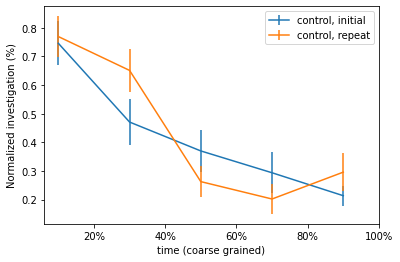

In [55]:
plt.errorbar(range(5), pred_matrix_control_first_norm, pred_matrix_control_first_norm_se, label = 'control, initial')
plt.errorbar(range(5), pred_matrix_control_second_norm, pred_matrix_control_second_norm_se, label = 'control, repeat')
plt.legend()

x_label_list = ['20%', '40%', '60%', '80%', '100%']
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], labels = x_label_list)

plt.ylabel('Normalized investigation (%)')
plt.xlabel('time (coarse grained)');

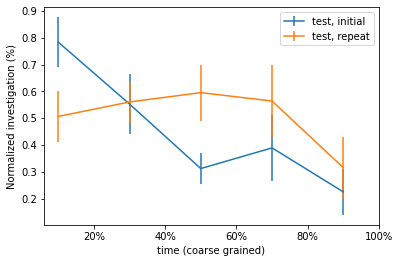

In [ ]:
plt.errorbar(range(5), pred_matrix_test_first_norm, pred_matrix_test_first_norm_se, label = 'test, initial')
plt.errorbar(range(5), pred_matrix_test_second_norm, pred_matrix_test_second_norm_se, label = 'test, repeat')
plt.ylabel('Normalized investigation (%)')
plt.xlabel('time (coarse grained)')

x_label_list = ['20%', '40%', '60%', '80%', '100%']
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], labels = x_label_list)

plt.legend()

Repeat with the unnormalized traces

In [69]:
pred_matrix_control_first_se = np.std(pred_matrix_control_first, axis = 0)/np.sqrt(n_control)
pred_matrix_control_first_mean = np.mean(pred_matrix_control_first, axis = 0)

pred_matrix_control_second_se = np.std(pred_matrix_control_second, axis = 0)/np.sqrt(n_control)
pred_matrix_control_second_mean = np.mean(pred_matrix_control_second, axis = 0)

pred_matrix_test_first_se = np.std(pred_matrix_test_first, axis = 0)/np.sqrt(n_test)
pred_matrix_test_first_mean = np.mean(pred_matrix_test_first, axis = 0)

pred_matrix_test_second_se = np.std(pred_matrix_test_second, axis = 0)/np.sqrt(n_test)
pred_matrix_test_second_mean = np.mean(pred_matrix_test_second, axis = 0)

In [70]:
#Rank sums results
control_sigs = []
for idx in range(5):
    print(ranksums(pred_matrix_control_first[:,idx], pred_matrix_control_second[:,idx]))

RanksumsResult(statistic=-0.838552760240712, pvalue=0.40172032908792543)
RanksumsResult(statistic=-1.0549534725608958, pvalue=0.29144660464450534)
RanksumsResult(statistic=1.0279033835208728, pvalue=0.3039952778179398)
RanksumsResult(statistic=0.5274767362804479, pvalue=0.5978625674290079)
RanksumsResult(statistic=0.1623005342401378, pvalue=0.8710691939955636)


In [71]:
#Rank sums results
test_sigs = []
for idx in range(5):
    print(ranksums(pred_matrix_test_first[:,idx], pred_matrix_test_second[:,idx]))

RanksumsResult(statistic=0.9271726499455306, pvalue=0.35383690068472917)
RanksumsResult(statistic=-0.4856618642571827, pvalue=0.6272069263720121)
RanksumsResult(statistic=-1.280381278496209, pvalue=0.20041107494054256)
RanksumsResult(statistic=-1.280381278496209, pvalue=0.20041107494054256)
RanksumsResult(statistic=-0.6622661785325219, pvalue=0.5078006482752733)


Thus none of these are significant differences

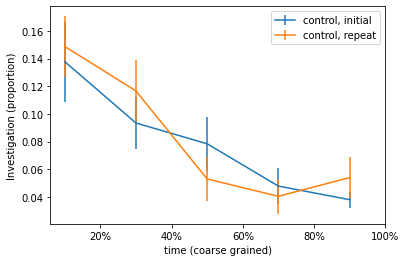

In [72]:
plt.errorbar(range(5), pred_matrix_control_first_mean, pred_matrix_control_first_se, label = 'control, initial')
plt.errorbar(range(5), pred_matrix_control_second_mean, pred_matrix_control_second_se, label = 'control, repeat')
plt.legend()

x_label_list = ['20%', '40%', '60%', '80%', '100%']
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], labels = x_label_list)

plt.ylabel('Investigation (proportion)')
plt.xlabel('time (coarse grained)');
plt.savefig('./control_coarse_grained_summary.pdf')

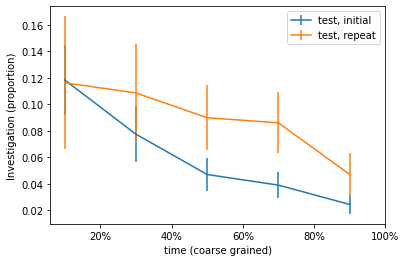

In [73]:
plt.errorbar(range(5), pred_matrix_test_first_mean, pred_matrix_test_first_se, label = 'test, initial')
plt.errorbar(range(5), pred_matrix_test_second_mean, pred_matrix_test_second_se, label = 'test, repeat')
plt.ylabel('Investigation (proportion)')
plt.xlabel('time (coarse grained)')

x_label_list = ['20%', '40%', '60%', '80%', '100%']
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], labels = x_label_list)

plt.legend()
plt.savefig('./test_coarse_grained_summary.pdf')

Repeat only with the 'initially interested' mice

In [63]:
#Which indices are these?
files_to_include = list(pd.merge(concise_results_w_threhsold.reset_index(), results, on = 'trial').filename)

indices_pred_matrix_control_first = [fn in files_to_include for fn in name_pred_matrix_control_first]
indices_pred_matrix_control_second = [fn in files_to_include for fn in name_pred_matrix_control_second]
indices_pred_matrix_test_first = [fn in files_to_include for fn in name_pred_matrix_test_first]
indices_pred_matrix_test_second = [fn in files_to_include for fn in name_pred_matrix_test_second]

indices_pred_matrix_test_second

[True, True, True, False, False, False, True, False, False]

In [78]:
## The same plots but excluding the 'initially unintestered' mice
pred_matrix_control_first_se = np.std(pred_matrix_control_first[indices_pred_matrix_control_first,:], axis = 0)/np.sqrt(n_control)
pred_matrix_control_first_mean = np.mean(pred_matrix_control_first[indices_pred_matrix_control_first,:], axis = 0)

pred_matrix_control_second_se = np.std(pred_matrix_control_second[indices_pred_matrix_control_second,:], axis = 0)/np.sqrt(n_control)
pred_matrix_control_second_mean = np.mean(pred_matrix_control_second[indices_pred_matrix_control_second,:], axis = 0)

pred_matrix_test_first_se = np.std(pred_matrix_test_first[indices_pred_matrix_test_first,:], axis = 0)/np.sqrt(n_test)
pred_matrix_test_first_mean = np.mean(pred_matrix_test_first[indices_pred_matrix_test_first,:], axis = 0)

pred_matrix_test_second_se = np.std(pred_matrix_test_second[indices_pred_matrix_test_second,:], axis = 0)/np.sqrt(n_test)
pred_matrix_test_second_mean = np.mean(pred_matrix_test_second[indices_pred_matrix_test_second,:], axis = 0)

In [85]:
#Rank sums results
for idx in range(5):
    print(ranksums(pred_matrix_control_first[indices_pred_matrix_control_first,idx], pred_matrix_control_second[indices_pred_matrix_control_second,idx]))

RanksumsResult(statistic=-0.4535573676110727, pvalue=0.6501474440948545)
RanksumsResult(statistic=0.07559289460184544, pvalue=0.9397429895770734)
RanksumsResult(statistic=1.360672102833218, pvalue=0.17361733442494354)
RanksumsResult(statistic=0.8315218406202999, pvalue=0.40567889528505297)
RanksumsResult(statistic=1.4362649974350634, pvalue=0.15092695006671628)


In [86]:
#Rank sums results
for idx in range(5):
    print(ranksums(pred_matrix_test_first[indices_pred_matrix_test_first,idx], pred_matrix_test_second[indices_pred_matrix_test_second,idx]))

RanksumsResult(statistic=0.0, pvalue=1.0)
RanksumsResult(statistic=-1.1547005383792517, pvalue=0.24821307898992362)
RanksumsResult(statistic=-1.7320508075688774, pvalue=0.0832645166635504)
RanksumsResult(statistic=-1.4433756729740645, pvalue=0.14891467317876572)
RanksumsResult(statistic=-1.1547005383792517, pvalue=0.24821307898992362)


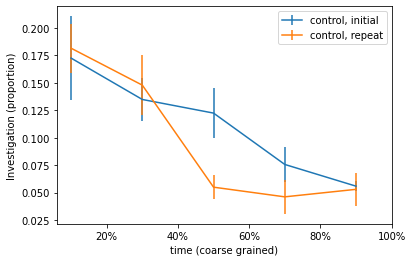

In [67]:
plt.errorbar(range(5), pred_matrix_control_first_mean, pred_matrix_control_first_se, label = 'control, initial')
plt.errorbar(range(5), pred_matrix_control_second_mean, pred_matrix_control_second_se, label = 'control, repeat')
plt.legend()

x_label_list = ['20%', '40%', '60%', '80%', '100%']
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], labels = x_label_list)

plt.ylabel('Investigation (proportion)')
plt.xlabel('time (coarse grained)');
plt.savefig('./control_coarse_grained_summary_w_threshold.pdf')

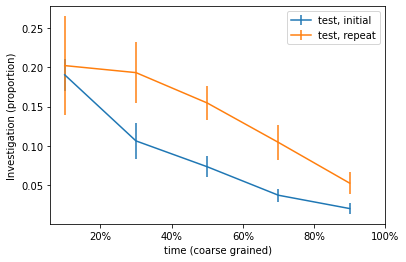

In [68]:
plt.errorbar(range(5), pred_matrix_test_first_mean, pred_matrix_test_first_se, label = 'test, initial')
plt.errorbar(range(5), pred_matrix_test_second_mean, pred_matrix_test_second_se, label = 'test, repeat')
plt.ylabel('Investigation (proportion)')
plt.xlabel('time (coarse grained)')

x_label_list = ['20%', '40%', '60%', '80%', '100%']
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], labels = x_label_list)

plt.legend()
plt.savefig('./test_coarse_grained_summary_w_threshold.pdf')

### Coarse grained plots

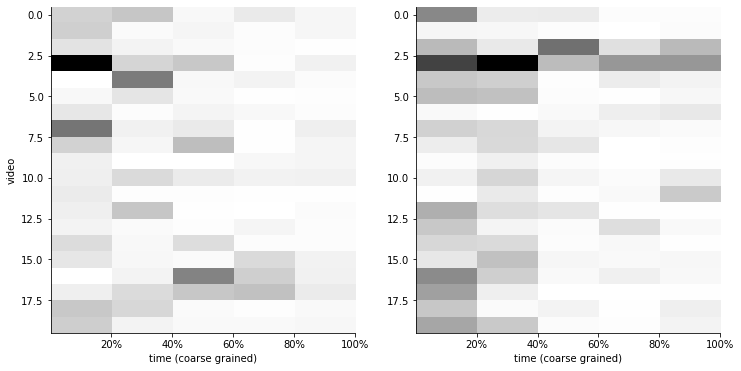

In [83]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize = (12,6), sharex = True)
ax[0].imshow(pred_matrix_control_first, aspect = 'auto', interpolation = 'none', cmap = 'Greys')
ax[1].imshow(pred_matrix_control_second, aspect = 'auto', interpolation = 'none', cmap = 'Greys')
sns.despine()
ax[1].set_xlabel('time (coarse grained)')
ax[0].set_xlabel('time (coarse grained)')
ax[0].set_ylabel('video');

x_label_list = ['20%', '40%', '60%', '80%', '100%']
ax[0].set_xticks([0.5, 1.5, 2.5, 3.5, 4.5])
ax[0].set_xticklabels(x_label_list)

plt.savefig('./control_predicted_interactions_coarse_grained.png', dpi = 100)

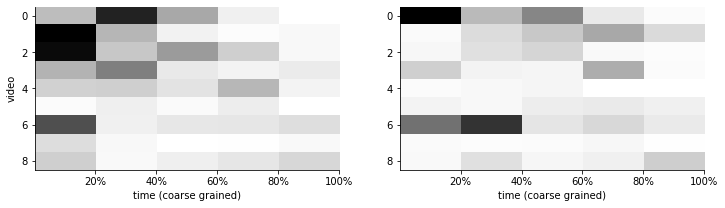

In [84]:
fig, ax = plt.subplots(1, 2, figsize = (12,3), sharex = True)
ax[0].imshow(pred_matrix_test_first, aspect = 'auto', interpolation = 'none', cmap = 'Greys')
ax[1].imshow(pred_matrix_test_second, aspect = 'auto', interpolation = 'none', cmap = 'Greys')
sns.despine()
ax[1].set_xlabel('time (coarse grained)')
ax[0].set_xlabel('time (coarse grained)')
ax[0].set_ylabel('video');

x_label_list = ['20%', '40%', '60%', '80%', '100%']
ax[0].set_xticks([0.5, 1.5, 2.5, 3.5, 4.5])
ax[0].set_xticklabels(x_label_list)

plt.savefig('./test_predicted_interactions_coarse_grained.png', dpi = 100)

In [ ]:
#TODO:

#DONE
# Split this plot into test groups
# Report accuracies
# Show videos of predictions

# To present:
# * We have pretty good behavior prediction:
# *  prediction F1 score, precision, recall
# * Sample behavior videos
# * The simple rule of thumb measure of interactions -- should at least be consistent with these
# * The effect:
# *  Construct test for mean pct changes
# *  The effect quantified by up/down counts
# * Some other analysis:
# *  TSNE plot (not that exciting)
# * Questions:
# *  How else can we quantify the effect?
# *  What other analyses are of interest?


### Interaction time vs simple metrics

In [35]:
#Compute simple metric
col = 'MARS__M0_M1_dist_nose_neck'
thresh = 100
results['mean_pct_' + col] = 0
for fn in test_dataset.metadata.keys():
    d = test_dataset.data[test_dataset.data['filename'] == fn]
    simple_metric = 100*np.mean(d[col] < thresh)
    results.loc[results['filename'] == fn, 'mean_pct_' + col] = simple_metric

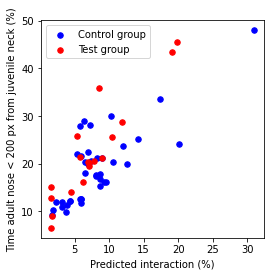

In [37]:
plot_scatter_w_legend(results['predicted_interaction_percent'].to_numpy(), 
                      results['mean_pct_MARS__M0_M1_dist_nose_neck'].to_numpy(), 
                      results['test_group_'].to_numpy(), 
                      {True: 'Test group', False: 'Control group'}, 
                      figsize = (4,4))
plt.xlabel('Predicted interaction (%)')
plt.ylabel('Time adult nose < 200 px from juvenile neck (%)');
plt.savefig('./test_vs_control_simple_measure_comparison.pdf')

### Embedding colored by predictions

In [125]:
tsne_cols = ['1dcnn__prob_attack',
                '1dcnn__prob_investigation',
                '1dcnn__prob_mount',
                '1dcnn__prob_other',
                'likelihood_adult_nose',
                'likelihood_adult_leftear',
                'likelihood_adult_rightear',
                'likelihood_adult_neck',
                'likelihood_adult_lefthip',
                'likelihood_adult_righthip',
                'likelihood_adult_tail',
                'likelihood_juvenile_nose',
                'likelihood_juvenile_leftear',
                'likelihood_juvenile_rightear',
                'likelihood_juvenile_neck',
                'likelihood_juvenile_lefthip',
                'likelihood_juvenile_righthip',
                'likelihood_juvenile_tail']


Text(0, 0.5, 'TSNE dim 2')

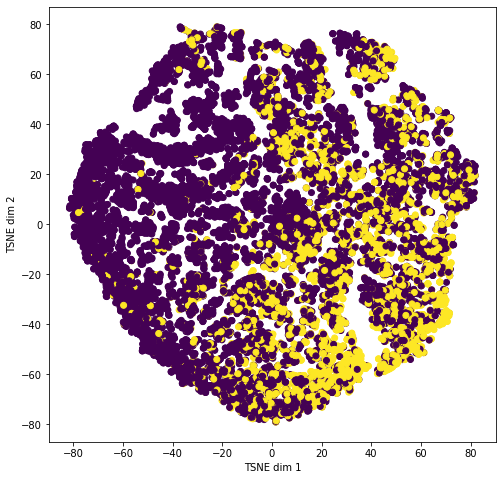

In [198]:
#Z-score before embedding
N_rows = 20000
row_filter = test_dataset.data['MARS__M0_M1_dist_nose_neck'] < 200
tsne_data = test_dataset.data.loc[row_filter, tsne_cols + ['filename', 'prediction']]

tsne_data_ = pd.merge(tsne_data, results[['filename', 'test_group_', 'repeat']], on = 'filename')
tsne_data_

tsne_data = StandardScaler().fit_transform(tsne_data[tsne_cols])

random_indices = np.random.choice(tsne_data.shape[0], N_rows, replace = False)

tsne_data = tsne_data[random_indices, :]

tsne_embedding = TSNE(n_components=2, init = 'pca').fit_transform(tsne_data)
fig, axes = plt.subplots(1,1, figsize = (8,8))
axes.scatter(x = tsne_embedding[:,0], y = tsne_embedding[:,1], c = tsne_data_.loc[random_indices,'prediction'], s = 1)
axes.set_xlabel('TSNE dim 1')
axes.set_ylabel('TSNE dim 2')
plt.savefig('./tsne_embedding_colored_by_prediction.pdf')

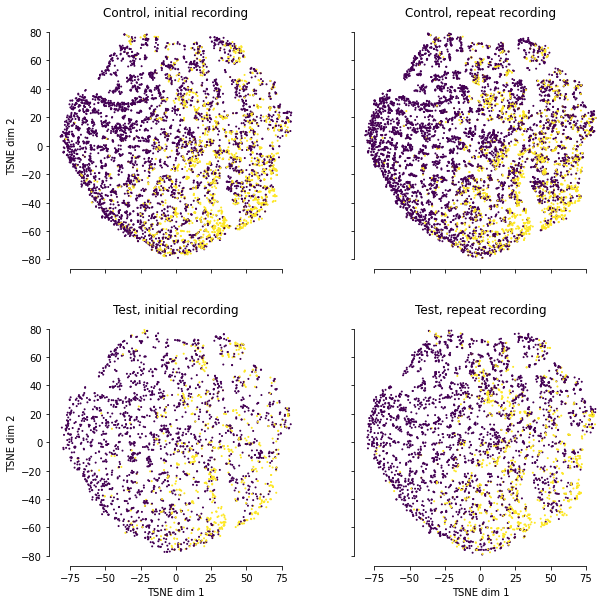

In [220]:
fig, axes = plt.subplots(2,2, figsize = (10,10), sharex = True, sharey = True)

indices = ((tsne_data_.loc[random_indices,'test_group_'] == False) & (tsne_data_.loc[random_indices,'repeat'] == False)).to_numpy()
color = (tsne_data_.loc[random_indices,'prediction'][indices]).to_numpy()
axes[0,0].scatter(x = tsne_embedding[indices,0], y = tsne_embedding[indices,1], s = 1, c = color)
axes[0,0].set_ylabel('TSNE dim 2')
axes[0,0].set_title('Control, initial recording')

indices = ((tsne_data_.loc[random_indices,'test_group_'] == False) & (tsne_data_.loc[random_indices,'repeat'] == True)).to_numpy()
color = (tsne_data_.loc[random_indices,'prediction'][indices]).to_numpy()
axes[0,1].scatter(x = tsne_embedding[indices,0], y = tsne_embedding[indices,1], s = 1, c = color)
axes[0,1].set_title('Control, repeat recording')

indices = ((tsne_data_.loc[random_indices,'test_group_'] == True) & (tsne_data_.loc[random_indices,'repeat'] == False)).to_numpy()
color = (tsne_data_.loc[random_indices,'prediction'][indices]).to_numpy()
axes[1,0].scatter(x = tsne_embedding[indices,0], y = tsne_embedding[indices,1], s = 1, c = color)
axes[1,0].set_xlabel('TSNE dim 1')
axes[1,0].set_ylabel('TSNE dim 2')
axes[1,0].set_title('Test, initial recording')

indices = ((tsne_data_.loc[random_indices,'test_group_'] == True) & (tsne_data_.loc[random_indices,'repeat'] == True)).to_numpy()
color = (tsne_data_.loc[random_indices,'prediction'][indices]).to_numpy()
axes[1,1].scatter(x = tsne_embedding[indices,0], y = tsne_embedding[indices,1], s = 1, c = color)
axes[1,1].set_xlabel('TSNE dim 1')
axes[1,1].set_title('Test, repeat recording')
sns.despine(trim = True)
plt.savefig('./tsne_embedding_colored_by_prediction_by_subtype.pdf')

In [187]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
indices = (tsne_data_.loc[random_indices,'test_group_'] == True).to_numpy()
color = (tsne_data_.loc[random_indices,'prediction'][indices]).to_numpy()
axes[0].scatter(x = tsne_embedding[indices,0], y = tsne_embedding[indices,1], s = 1, c = color)
axes[0].set_xlabel('TSNE dim 1')
axes[0].set_ylabel('TSNE dim 2')

color = (tsne_data_.loc[random_indices,'prediction'][(1-indices).astype(bool)]).to_numpy()
axes[1].scatter(x = tsne_embedding[(1-indices).astype(bool),0], y = tsne_embedding[(1-indices).astype(bool),1], s = 1, c = color)
axes[1].set_xlabel('TSNE dim 1')
axes[1].set_ylabel('TSNE dim 2')


,filename,test_group_
0,./all_videos/e3v813a-20211001T121054-121622DLC...,False
1,./all_videos/e3v813a-20211001T122726-123223DLC...,False
2,./all_videos/e3v813a-20211001T123846-124419DLC...,False
3,./all_videos/e3v813a-20211001T125501-130007DLC...,False
4,./all_videos/e3v813a-20211001T132205-132735DLC...,False
5,./all_videos/e3v813a-20211001T133723-134310DLC...,False
6,./all_videos/e3v813a-20211001T135129-135613DLC...,False
7,./all_videos/e3v813a-20211001T140617-141120DLC...,False
8,./all_videos/e3v813a-20211006T110049-110522DLC...,False
9,./all_videos/e3v813a-20211006T111208-111713DLC...,False


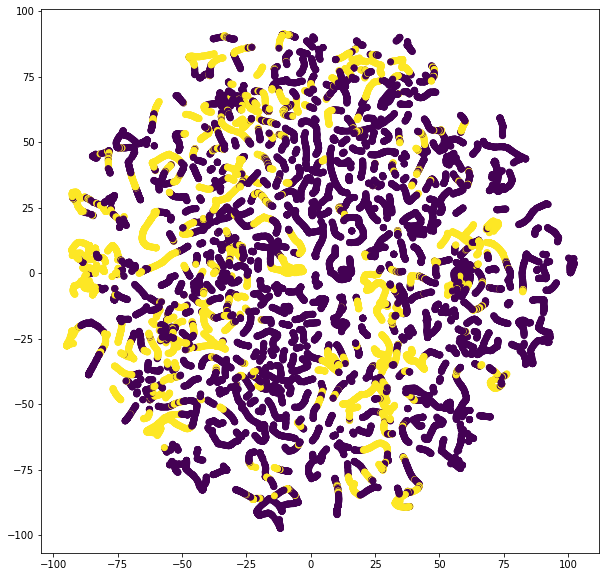

In [43]:
#Perform PCA before computing embedding

#Z-score before embedding

row_filter = dataset.data['MARS__M0_M1_dist_nose_neck'] < 200
tsne_data = dataset.data.loc[row_filter, dataset.feature_cols]

tsne_data = StandardScaler().fit_transform(tsne_data)
tsne_data = PCA(n_components = 100).fit_transform(tsne_data)

tsne_embedding = TSNE(n_components=2, init = 'pca').fit_transform(tsne_data)
fig, axes = plt.subplots(1,1, figsize = (10,10))
axes.scatter(x = tsne_embedding[:,0], y = tsne_embedding[:,1], c = dataset.data.loc[row_filter, 'prediction'])

In [31]:
#Take a larger set of features first

In [32]:
#Then perform PCA on that larger set, first

## Try out UMAP

